In [1]:
import pydicom as dicom
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2 

In [2]:
# path = os.path.join(os.path.dirname(os.getcwd()), 'DICOM_files')
path = 'C://Users\mario\DataspellProjects\dicom_files_python'
path = os.path.join(path, 'DICOM_files')
dicom_files = os.listdir(path)

dicom_images = [dicom.dcmread(os.path.join(path, dcm_path)) for dcm_path in dicom_files if dcm_path.endswith('.dcm')]

ds = dicom_images[0]
pixel_data = ds.pixel_array

def img_uint8(pixel_array):
    return (pixel_array / pixel_array.max() * 255).astype(np.uint8)

pixel_data_uint16 = ds.pixel_array
pixel_data_uint8 = img_uint8(ds.pixel_array)

In [9]:
def extract_dicom_info(sls, include, exclude):
    # First let's handle the tags 
    tags = []
    for tag in include:
        tags += list(sls[0].group_dataset(tag).keys())
    if len(exclude)!=0:
        tags = [tag for tag in tags if tag not in exclude]
    # We initialize the data list with a list comprehension, 
    # ensuring that each dictionary in the list contains the same 
    # keys (columns) with initial values set to NaN. 
    # It creates a lit of dictionaries, each element of the list is composed of: 
    # [{Image: Image0, (0x00100010): NaN, (...)}, {Image: Image1, (0x00100010): NaN, (...)}]
    data = [{'Image': f'Image{i}', **{tag: np.nan for tag in tags}} for i in range(len(dicom_images))]
    for i, ds in enumerate(dicom_images):
        # Inside the loop, we update the values in each dictionary 
        # based on the available DICOM data, leaving the value as NaN if an error occurs.
        for key in tags:
            try:
                value = ds[key].value
                # Update the dictionary with valid values where available
                data[i][key] = value
            except Exception as e:
                pass  # Leave the value as NaN if an error occurs
    # Create a DataFrame from the list of dictionaries
    dicom_df = pd.DataFrame(data)
    names = [sls[0][k].name for k in tags]
    dicom_df.columns = (['Image'] + names)
    return dicom_df


include_tags = [0x0010, 0x0028, 0x0008]
# 0x0010, 0x0028, 0x0008
exclude_keys = [0x00100010, 0x00100030, 
                0x00281050, 0x00281051, 0x00281052, 0x00281053,
                0x00080005, 0x00080016, 0x00080018, 0x00080020,
                0x00080021, 0x00080022, 0x00080023,
                0x00080030, 0x00080031, 0x00080032, 0x00080033,
                0x00080050, 0x00080070, 0x00080080, 0x00080081,
                0x00080090, 0x00081010, 0x0008103e, 0x00081090
                ]
dcm_info_df = extract_dicom_info(dicom_images, include_tags, exclude_keys)
dcm_info_df

,Image,Patient ID,Patient's Sex,Patient's Age,Samples per Pixel,Photometric Interpretation,Rows,Columns,Pixel Spacing,Bits Allocated,Bits Stored,High Bit,Pixel Representation,Smallest Image Pixel Value,Largest Image Pixel Value,Image Type,Modality,Study Description
0,Image0,65259,F,094Y,1,MONOCHROME2,512,512,"[0.4609375, 0.4609375]",16,16,15,0,0.0,3467.0,"[ORIGINAL, PRIMARY, AXIAL, CT_SOM5 SEQ]",CT,Cabeza^HeadSeq (Adulto)
1,Image1,570,F,055Y,1,MONOCHROME2,512,512,"[0.748046875, 0.748046875]",16,16,15,0,0.0,2116.0,"[ORIGINAL, PRIMARY, AXIAL, HELIX]",CT,ONCOLOGIA
2,Image2,570,F,055Y,1,MONOCHROME2,512,512,"[0.748046875, 0.748046875]",16,16,15,0,0.0,2192.0,"[ORIGINAL, PRIMARY, AXIAL, HELIX]",CT,ONCOLOGIA
3,Image3,NOID,M,038Y,1,MONOCHROME2,512,512,"[0.427734375, 0.427734375]",16,12,11,0,NaN,NaN,"[ORIGINAL, PRIMARY, AXIAL, CT_SOM5 SEQ]",CT,Cabeza^HeadSeq (Adulto)
4,Image4,164789,F,070Y,1,MONOCHROME2,2294,1916,"[0.0940909087658, 0.0940909087658]",16,16,15,0,0.0,2773.0,"[ORIGINAL, SECONDARY]",MG,NaN
5,Image5,CAIS,F,NaN,1,MONOCHROME2,256,256,"[0.8984375, 0.8984375]",16,12,11,0,NaN,NaN,"[ORIGINAL, PRIMARY, M_SE, M, SE]",MR,CRANEO Y CAIS S/C/C
6,Image6,1.1465731,M,062Y,1,MONOCHROME2,512,512,"[0.73046875, 0.73046875]",16,16,15,1,NaN,NaN,"[DERIVED, SECONDARY, REFORMATTED, AVERAGE]",CT,Torax
7,Image7,570,F,055Y,1,MONOCHROME2,512,512,"[0.748046875, 0.748046875]",16,16,15,0,0.0,4000.0,"[ORIGINAL, PRIMARY, AXIAL, HELIX]",CT,ONCOLOGIA
8,Image8,NOID,M,038Y,1,MONOCHROME2,512,512,"[0.427734375, 0.427734375]",16,12,11,0,NaN,NaN,"[ORIGINAL, PRIMARY, AXIAL, CT_SOM5 SEQ]",CT,Cabeza^HeadSeq (Adulto)
9,Image9,AN0062426369,M,NaN,1,MONOCHROME2,384,384,"[0.9765625, 0.9765625]",16,12,11,0,NaN,NaN,"[ORIGINAL, PRIMARY, M_SE, M, SE]",MR,ABD-PELV


In [18]:
# dcm_info_df = dcm_info_df.drop(['Photometric Interpretation', 'Pixel Representation', 'Pixel Spacing', 'High Bit'], axis=1)

df = pd.DataFrame(data=dcm_info_df.iloc[0, :])
print(df)
'''
print(df.to_latex(index=False,
                   float_format="{:.1f}".format,
                   ))
                   '''


                                                                  0
Image                                                        Image0
Patient ID                                                    65259
Patient's Sex                                                     F
Patient's Age                                                  094Y
Samples per Pixel                                                 1
Photometric Interpretation                              MONOCHROME2
Rows                                                            512
Columns                                                         512
Pixel Spacing                                [0.4609375, 0.4609375]
Bits Allocated                                                   16
Bits Stored                                                      16
High Bit                                                         15
Pixel Representation                                              0
Smallest Image Pixel Value                      

'\nprint(df.to_latex(index=False,\n                   float_format="{:.1f}".format,\n                   ))\n                   '

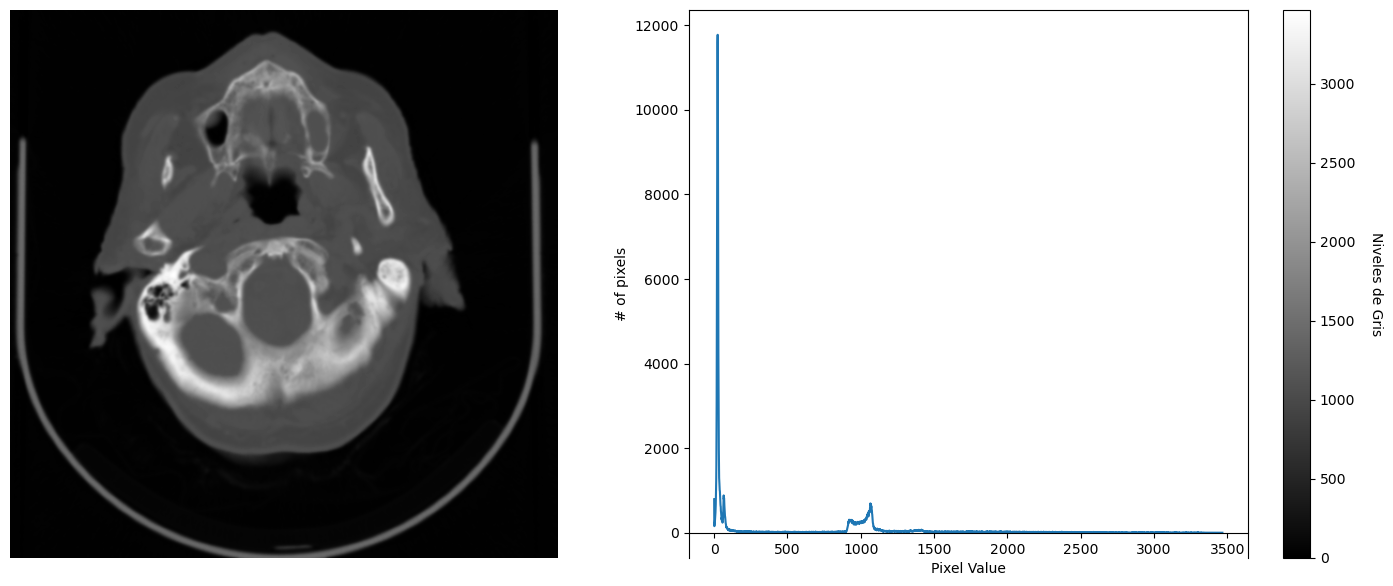

In [21]:
def histogram(image):
    bins = np.max(image)
    # Calculate the histogram
    # We need to pass a list of images, therefor [images]
    # We only have one channel (gray), so [0]
    # We don't want to provide a mask, so None
    # The number of bins is given by the user, but for default, is 256
    # The range will be from 0 to 256 since we have a uint8 image with 256 shades of gray
    hist = cv2.calcHist([image], [0], None, [bins], [0, bins])
    #Matplotlib code to visualize the histogram
    plt.figure(figsize=(8,5))
    plt.title('Grayscale histogram')
    plt.xlabel('Bins')
    plt.ylabel('# of pixels')
    plt.plot(hist)
    plt.xlim(-1, 256)
    plt.show()
    return None

def histogram_image(image):
    fig, axes = plt.subplots(1, 2, figsize=(15,6))
    
    #Plot the image
    im = axes[0].imshow(image, cmap='gray')
    axes[0].axis('off')
    
    bins = np.max(image)
    # Plot the histogram
    hist = cv2.calcHist([image], [0], None, [bins], [0, bins])
    axes[1].plot(hist)
    axes[1].set_xlabel("Pixel Value")
    axes[1].set_ylabel("# of pixels")

    # Move the x-axis to y=0
    axes[1].spines['bottom'].set_position('zero')

    
    cbar = plt.colorbar(im, ax=axes[1])
    cbar.set_label('Niveles de Gris', rotation=270, labelpad=20)
    
    plt.tight_layout()
    plt.show()
    
    return None


histogram_image(pixel_data_uint16)

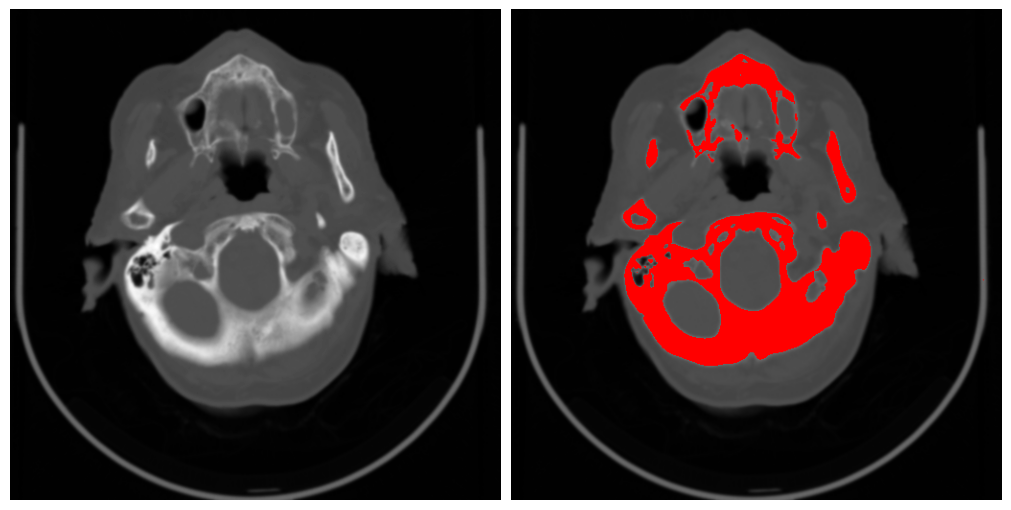

array([[[1, 1, 1],
        [1, 1, 1],
        [2, 2, 2],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [2, 2, 2],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       ...,

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]]], dtype=uint8)

In [45]:
def apply_red_mask_to_dicom(image, min, max, plots=True):
    # Create a new dimension for the other 3 colors: RGB
    masked_image = np.stack([image]*3, axis=2)
    # Create the mask
    mask = (image >= min) & (image <= max)
    # Apply the mask
    masked_image[mask] = [255, 0, 0]
    
    # Plot
    if plots:
        fig, axes = plt.subplots(1, 2, figsize=(10, 10), layout='constrained')
        axes[0].imshow(image, cmap='gray')
        axes[0].axis('off')
        axes[1].imshow(masked_image)
        axes[1].axis('off')
        plt.show()
    return masked_image
    
apply_red_mask_to_dicom(pixel_data_uint8, 106, 255)
    

In [23]:
def scale_image(image, scaling_factor, interpolation=cv2.INTER_CUBIC):
    """
    :param image: Input pixel array
    :param scaling_factor: the scaling factor for the image, x2 doubles the size
    :param interpolation: Interpolation method for filling the new pixel data, INTER_CUBIC for default
                          possible values: cv2.INTER_NEAREST, cv2.INTER_LINEAR, cv2.INTER_CUBIC, cv2.INTER_LANCZOS4
    :return: 
    """
    if interpolation not in [cv2.INTER_NEAREST, cv2.INTER_LINEAR, cv2.INTER_CUBIC, cv2.INTER_LANCZOS4]:
        raise Exception(f'Interpolation method not recognised: {interpolation}')
    return cv2.resize(image, None, fx=scaling_factor, fy=scaling_factor, interpolation=interpolation).astype('uint8')

#Upscale
upscaled_image = scale_image(pixel_data, 2)
# Display the image using OpenCV
cv2.imshow('DICOM Image', upscaled_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

#### Interpolation

Interpolation in the context of image processing refers to the method used to estimate the pixel values at non-integer coordinates when you resize or transform an image. When you upscale (enlarge) or downscale (shrink) an image, you need to determine the color or intensity of the pixels at the new locations, which may not align precisely with the original pixel grid.

Different interpolation methods provide different trade-offs between computational efficiency and image quality. Here are some common interpolation methods used in image processing:

1. **Nearest-Neighbor Interpolation**: This method assigns the value of the nearest neighboring pixel to the new location. It's the fastest but can result in blocky or pixelated artifacts, especially when upscaling.

2. **Bilinear Interpolation**: Bilinear interpolation calculates the new pixel value as a weighted average of the four nearest pixels in a 2x2 neighborhood. It produces smoother results than nearest-neighbor interpolation but may still introduce some blurring.

3. **Bicubic Interpolation**: Bicubic interpolation considers a larger neighborhood of 4x4 pixels and uses cubic polynomials to estimate the new pixel values. It offers higher quality than bilinear interpolation and is commonly used for upscaling and downscaling.

4. **Lanczos Interpolation**: Lanczos interpolation is a more advanced method that uses a sinc function as the interpolation kernel. It produces high-quality results and is often used for image resizing when preserving fine details is essential.

In OpenCV's cv2.resize() function, you can specify the interpolation method using the interpolation parameter. The common options are cv2.INTER_NEAREST (nearest-neighbor), cv2.INTER_LINEAR (bilinear), cv2.INTER_CUBIC (bicubic), and cv2.INTER_LANCZOS4 (Lanczos). The choice of interpolation method should be based on your specific image processing needs.

In [11]:
def get_negative_image(image):
    """
    :param image: (numpy.ndarray) Input image as a NumPy array.
    :return: numpy.ndarray: Negative image as a NumPy array.
    """
    # Make sure the input image is in grayscale
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Get the maximum pixel intensity value and calculate the negative 
    # image by subtracting pixel values from max intensity.
    # We create a LUT for computing the negative.
    table = np.array([(np.max(image) - i) for i in np.arange(0, 256)], dtype=np.uint8)
    negative = cv2.LUT(image.astype(np.uint8), table)
    return negative

# Get the negative of the input image
negative_image = get_negative_image(pixel_data)
# Display the original and negative images
cv2.imshow('Original Image', pixel_data)
cv2.imshow('Negative Image', negative_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

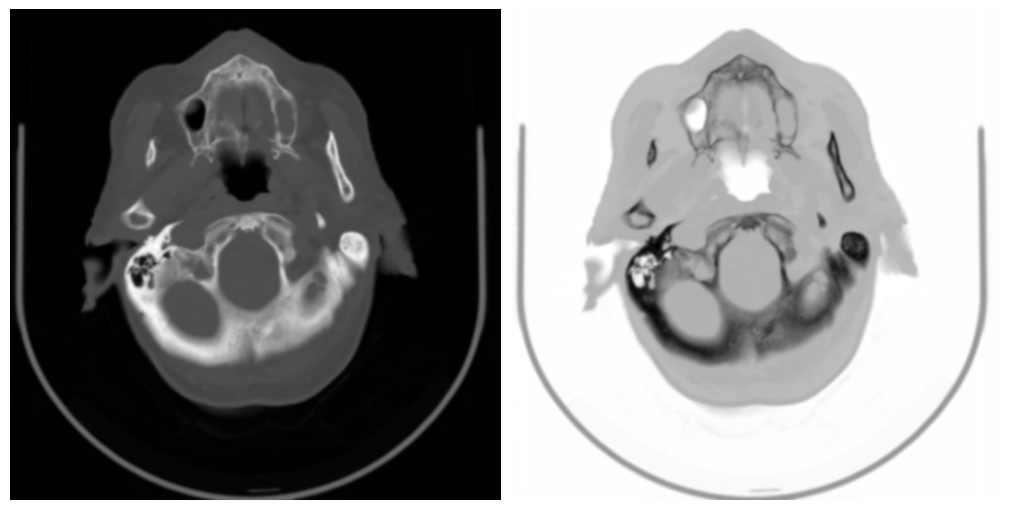

In [29]:
def get_negative(image):
    table = np.array([ (np.max(image) - i) for i in np.arange(0, 2**16)], dtype=image.dtype)
    negative = np.take(table, image)
    return negative

def plt_negative(image):
    fig, axes = plt.subplots(1, 2, figsize=(10, 10), layout='constrained')
    axes[0].imshow(image, cmap='gray')
    axes[0].axis('off')
    axes[1].imshow(get_negative(image), cmap='gray')
    axes[1].axis('off')
    plt.show()
    
plt_negative(pixel_data_uint8)

#### Negative Image

1. We start by ensuring that the input image is in grayscale. If it's a color image, we convert it to grayscale using cv2.cvtColor().

2. We determine the maximum pixel intensity value for the image, which is typically 255 for 8-bit images.

3. To create the negative image, we subtract each pixel value from the maximum intensity. This operation inverts the pixel values, effectively producing the negative of the original image.

4. The function returns the negative image as a NumPy array.

In the example usage, we load an image, get its negative using the get_negative_image function, and then display both the original and negative images using OpenCV.

In [ ]:
def adjust_gamma(image, gamma):
    """
    :param image: np.array of grayscale pixels
    :param gamma: gamma value, for this function we calculate the inverse
    :return: return the gamma-corrected image
    """
    invGamma = 1.0 / gamma
    table = np.array([ ((i/255)**invGamma)*255 for i in np.arange(0, 256)])
    #The LUT is calculated by raising each input value to the power of invGamma and then scaling the result to the 0-255 range. 
    # This step essentially computes the gamma correction for each possible input value.
    lut_img = cv2.LUT(image.astype(np.uint8), table.astype(np.uint8))
    return lut_img

gamma_val = 0.5
gamma_correction = adjust_gamma(pixel_data, gamma_val)
cv2.imshow('Original Image', pixel_data)
cv2.imshow('Gamma-corrected Image', gamma_correction)
cv2.waitKey(0)
cv2.destroyAllWindows()

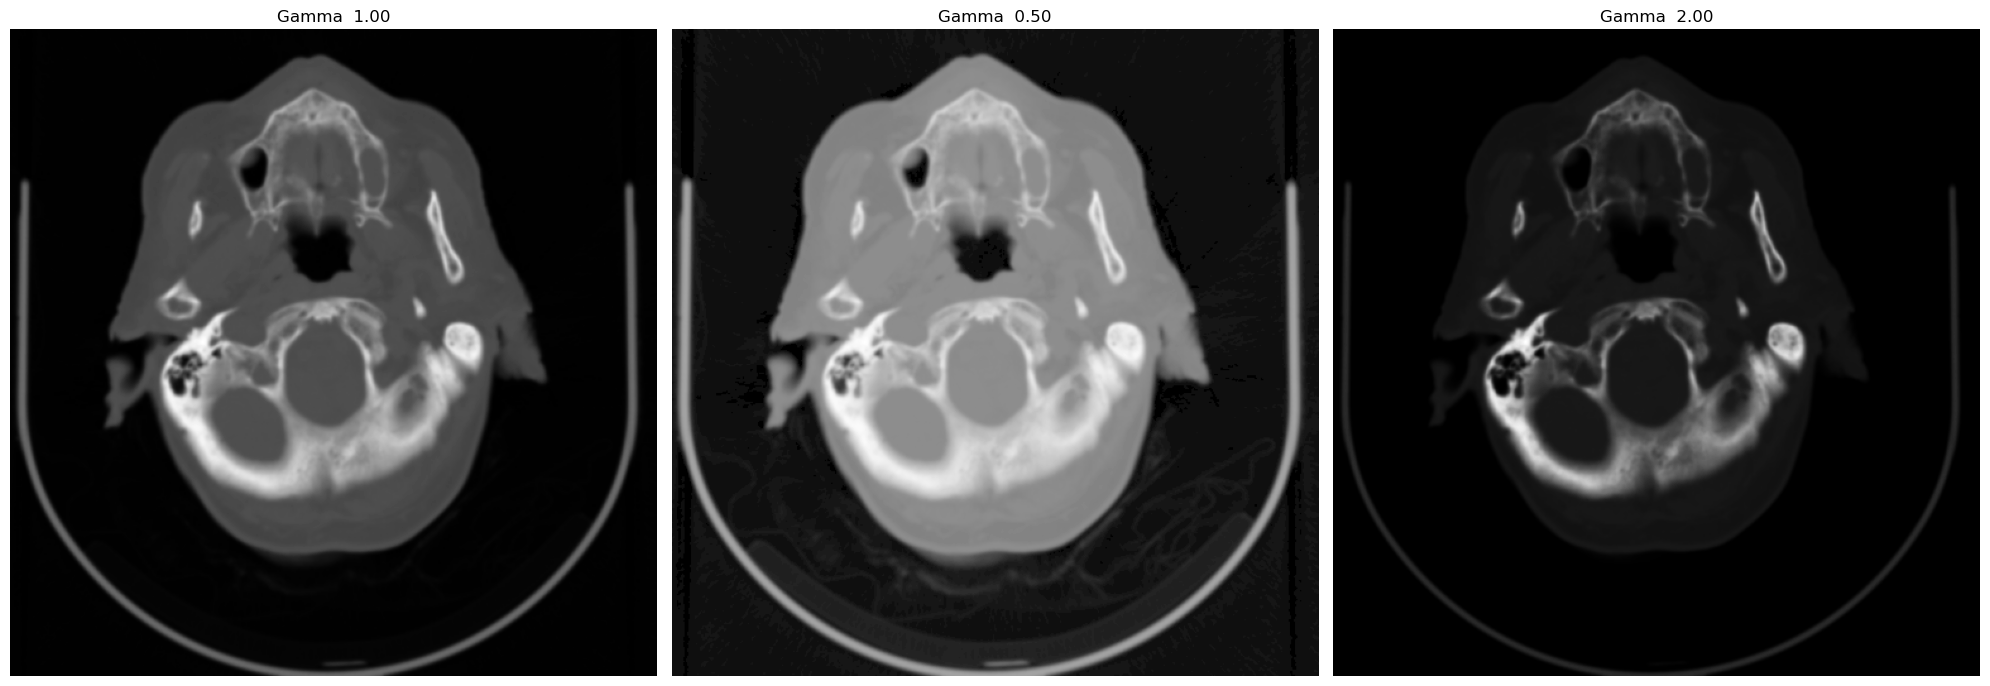

In [31]:
def adj_gamma(image, gamma):
    table = np.array([ ((i/255)**gamma)*255 for i in np.arange(0, 256)], dtype=np.uint8)
    return np.take(table, image)

def plt_gamma_images(image, gamma_vals):
    plt.figure(figsize=(20, 20))
    for i, gamma in enumerate(gamma_vals):
        adj_im = adj_gamma(image, gamma)
        plt.subplot(4, 4, i+1)
        plt.imshow(adj_im, cmap='gray')
        plt.title(f"Gamma {gamma: .2f}")
        plt.axis('off')
    plt.tight_layout()
    
def plt_gamma_imagesv2(image, gamma_vals):
    plt.figure(figsize=(20, 20))
    for i, gamma in enumerate(gamma_vals):
        adj_im = adj_gamma(image, gamma)
        plt.subplot(1, 3, i+1)
        plt.imshow(adj_im, cmap='gray')
        plt.title(f"Gamma {gamma: .2f}")
        plt.axis('off')
    plt.tight_layout()

plt_gamma_imagesv2(pixel_data_uint8, [1, 0.5, 2])

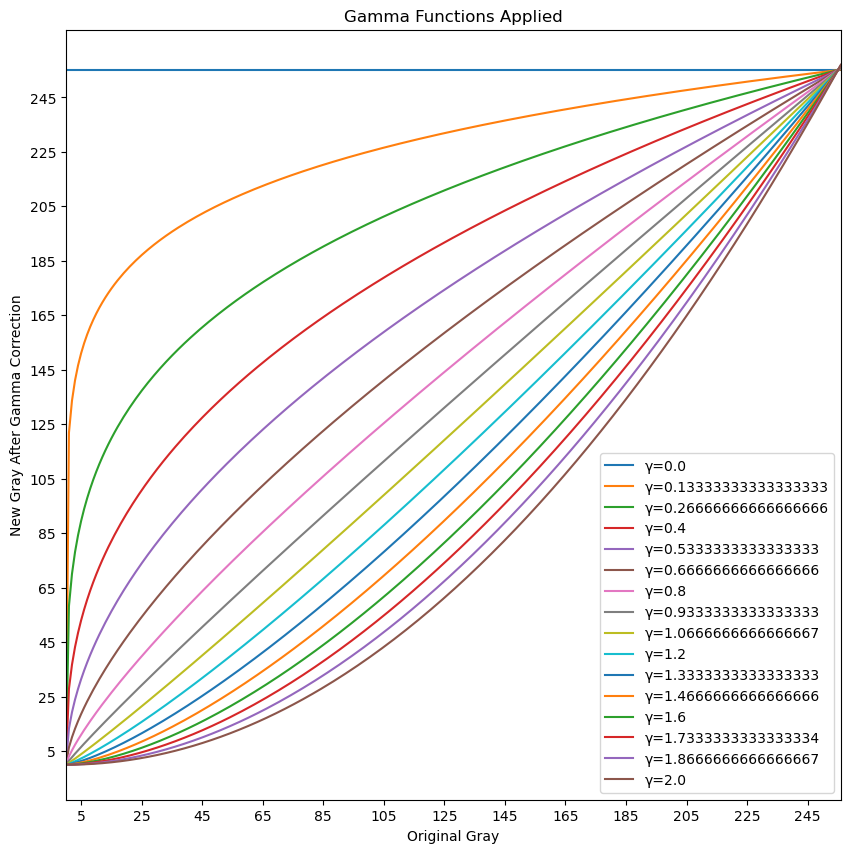

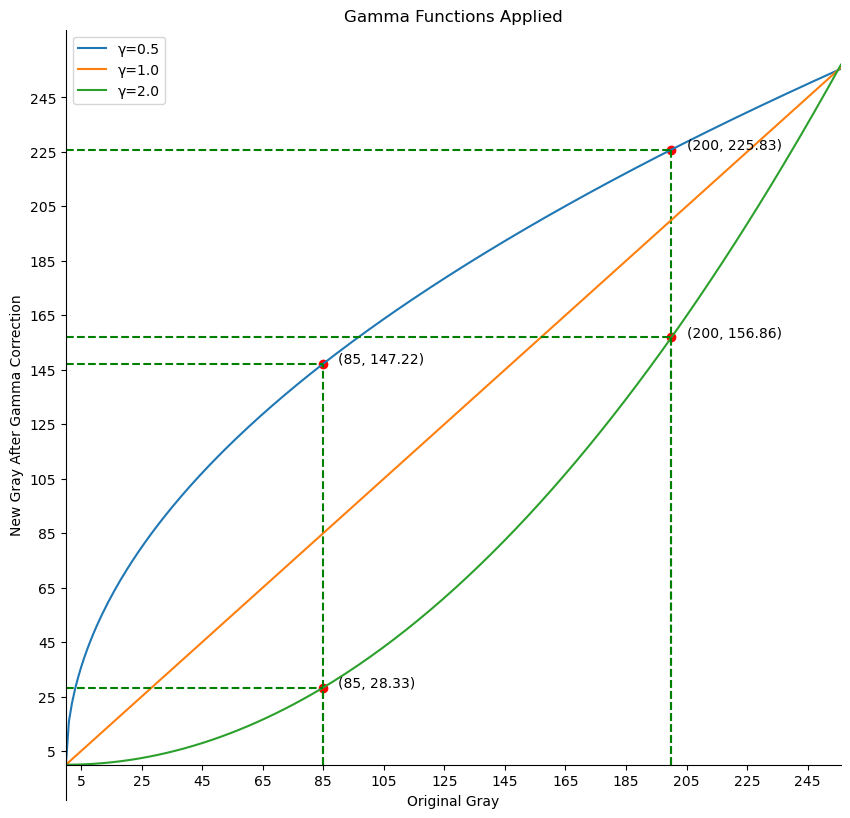

In [78]:
def gamma_function(gamma_vals, x, points=True):
    fig, ax = plt.subplots(figsize=(10, 10))

    for val in gamma_vals:
        y = 255 * (x / 255) ** val
        ax.plot(x, y, label=f'γ={val}')
        if val != 0 and val != 1 and points:
            #Colocamos los ejes
            ax.spines['left'].set_position('zero')
            ax.spines['right'].set_color('none')
            ax.spines['top'].set_color('none')
            ax.spines['bottom'].set_position('zero')
            for x_point in [85, 200]:
                y_point = 255 * (x_point / 255) ** val
                ax.scatter(x_point, y_point, color='red')
                # Dibujar líneas perpendiculares a los ejes para señalar las coordenadas
                ax.plot([x_point, x_point], [0, y_point], linestyle='--', color='green')
                ax.plot([0, x_point], [y_point, y_point], linestyle='--', color='green')
                # Marcamos los puntos
                ax.text(x_point + 5, y_point, f'({x_point}, {y_point:.2f})')
    ax.set_xlabel('Original Gray')
    ax.set_xlim([0, 256])
    ax.set_ylabel('New Gray After Gamma Correction')
    ax.set_title('Gamma Functions Applied')
    ax.set_xticks(np.arange(5, 255, 20))
    ax.set_yticks(np.arange(5, 255, 20))
    ax.legend()
    plt.show()
    
    
    plt.show()

x = np.linspace(0, 256, 256)
gamma_function(np.linspace(0, 2, 16), x, points=False)
gamma_function(np.array([0.5, 1, 2]), x, points=True)

#### Gamma correction

1. **Input Image**: Start with an input medical image where pixel values represent intensity or brightness.

2. **Gamma Value (γ)**: Choose a gamma value (γ), which is a parameter that determines the degree of gamma correction.
        - A gamma value greater than 1 increases contrast in dark regions.
        - A gamma value less than 1 increases contrast in bright regions.
        - γ = 1 corresponds to no gamma correction (linear mapping).

3. **Inverse Gamma (1/γ)**: Calculate the inverse of the chosen gamma value (1/γ). This step is done because gamma correction typically involves raising pixel values to the power of γ, and taking the inverse allows you to achieve the desired effect.

4. **Lookup Table (LUT)**: Create a lookup table (LUT) that maps each input pixel value to its gamma-corrected value. The LUT applies the gamma correction transformation efficiently to all pixel values.

5. **Apply LUT**: Apply the LUT to the input image using the cv2.LUT() function. Each pixel value in the image is replaced with its corresponding gamma-corrected value based on the LUT.

6. **Gamma-Corrected Image**: The result is a gamma-corrected image with adjusted brightness and contrast. Dark or bright regions are enhanced or suppressed based on the gamma value.

In [36]:
def sqr_correction(image):
    """
    :param image: Input pixel array
    :return: Image with square root correction
    """
    table = np.array([np.sqrt(i) for i in np.arange(0, 256)], dtype='uint8')
    sqrt_image = cv2.LUT(image.astype('uint8'), table)
    return sqrt_image

sqrt_dcm = sqr_correction(pixel_data)

# Let's upscale the images in order to see changes with more detail
upscaled_dcm = scale_image(pixel_data, 2)
upscaled_cqrt = scale_image(sqrt_dcm, 2)

# Show the images
cv2.imshow('DICOM Image', upscaled_dcm)
cv2.imshow('SQRT Image', upscaled_cqrt)
cv2.waitKey(0)
cv2.destroyAllWindows()

#### SQRT function to pixel value

Applying the np.sqrt function to all pixel data of a medical image is a form of square root correction. This correction is a type of image enhancement technique that is used for specific purposes in medical image processing. The primary purpose of applying square root correction to medical images is to improve the visibility of certain details or structures within the image, particularly when those details are present in the lower intensity range of the image.

Here's why square root correction is applied:

1. **Enhancing Low-Intensity Features**: In medical images, especially in modalities like X-rays and nuclear medicine, important anatomical or pathological features may be present in the lower range of intensity values. These features can sometimes be challenging to distinguish or visualize in the original image.

2. **Non-Linear Enhancement**: Square root correction is a non-linear enhancement technique. It effectively increases the contrast in the lower intensity regions of the image while leaving the higher intensity regions relatively unchanged. This means that subtle details in the lower intensity range become more pronounced.

3. **Noise Reduction**: In addition to contrast enhancement, square root correction can have a mild noise reduction effect. By compressing the lower intensity values, it can help reduce the influence of noise in these regions.

4. **Visual Interpretation**: The enhanced image resulting from square root correction is often more visually interpretable by radiologists or medical professionals. It can make it easier to identify and diagnose certain conditions or abnormalities.

In [24]:
def linear_adjustment(image, wmin, wmax):
    """
    :param image: Input pixel array
    :param wmin: Minimum window value
    :param wmax: Maximum window value
    :return: Adjusted image to the window
    """
    # Clip the pixel values to the specified window
    adj_im = np.clip(image, wmin, wmax)
    # Scale the pixel values to the full 0-255 range
    adj_im = ((adj_im - wmin) / (wmax - wmin) * 255).astype(np.uint8)
    return adj_im


# Define the optimal window range (adjust as needed)
window_min = 35
window_max = 200
# Apply linear adjustment to the image
adjusted_image = linear_adjustment(pixel_data, window_min, window_max)
# Upscale the images to apreciate the differences
upscaled_dcm = scale_image(pixel_data, 1.2)
upscaled_window = scale_image(adjusted_image, 1.2)
# Display the original and adjusted images
cv2.imshow('Original Image', upscaled_dcm)
cv2.imshow('Adjusted Image', upscaled_window)
cv2.waitKey(0)
cv2.destroyAllWindows()

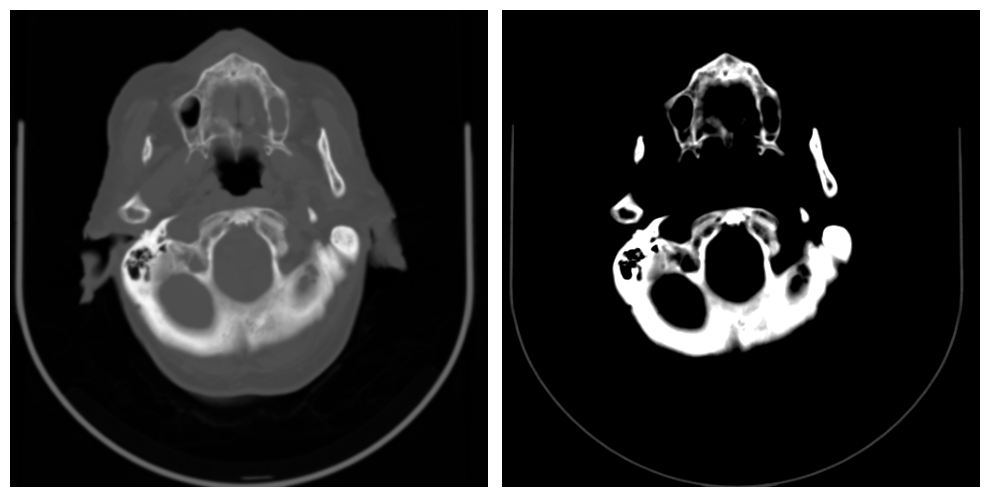

In [33]:
def lineal_window(image, wmin, wmax):
    
    adj = np.clip(image, wmin, wmax)
    adj = (((adj - wmin) / (wmax - wmin)) * np.max(image)).astype(image.dtype)
    return adj

def optimal_window_uint8():
    fig, axes = plt.subplots(1, 2, figsize=(10,10))
    axes[0].imshow(pixel_data_uint8, cmap='gray')
    axes[0].axis('off')
    axes[1].imshow(lineal_window(pixel_data_uint8, 88, 150), cmap='gray')
    axes[1].axis('off')
    plt.tight_layout()
    plt.show()

def optimal_window_uint16():
    fig, axes = plt.subplots(1, 2, figsize=(10,10))
    axes[0].imshow(pixel_data_uint16, cmap='gray')
    axes[0].axis('off')
    axes[1].imshow(lineal_window(pixel_data_uint16, 1200, 2500), cmap='gray')
    axes[1].axis('off')
    plt.show()
optimal_window_uint8()

#### Window (Lineal)

##### What is a window?
In the context of medical imaging and image processing, a "window" refers to a specific range or window of grayscale values that are selected from the entire grayscale spectrum of an image. This range is defined by two parameters: window_min and window_max.

Here's what these terms mean:

1. **Window Minimum** (window_min): This parameter represents the lower bound of the window. It is the minimum grayscale value within the selected range.

2. **Window Maximum** (window_max): This parameter represents the upper bound of the window. It is the maximum grayscale value within the selected range.

Together, window_min and window_max define the range of grayscale values that are considered relevant or optimal for visualizing specific anatomical structures or features within a medical image. Adjusting these values allows you to control the display of image details in a way that highlights the structures of interest while potentially suppressing irrelevant information.

For example, in a computed tomography (CT) scan of the abdomen, you might set a window range that emphasizes the contrast of liver tissue while reducing the visibility of surrounding tissues or artifacts. By selecting an appropriate window, you can enhance the visibility and diagnostic value of specific regions within a medical image.

##### Lineal Window Function

**Input Parameters**:
    image: This parameter is the input pixel array, typically representing a grayscale medical image.
    wmin: It represents the lower bound of the desired window range. Pixel values below wmin will be clipped to wmin.
    wmax: It represents the upper bound of the desired window range. Pixel values above wmax will be clipped to wmax.

**Clipping to the Window Range**:
    np.clip(image, wmin, wmax): This line of code clips the pixel values of the input image to the specified window range [wmin, wmax]. This means that any pixel values below wmin are set to wmin, and any pixel values above wmax are set to wmax. Clipping ensures that all pixel values in the output image fall within the desired window range.

**Scaling to 0-255 Range**:
    ((adj_im - wmin) / (wmax - wmin) * 255): After clipping, the pixel values within the window range are linearly scaled to the full 0-255 grayscale range. Here's how the scaling works:
        (adj_im - wmin) shifts the pixel values so that they start from 0 (essentially moving wmin to 0).
        (wmax - wmin) represents the range of values within the window.
        (adj_im - wmin) / (wmax - wmin) scales the values to the range [0, 1].
            * 255 scales the values to the full 0-255 range.

**Data Type Conversion**:
    .astype(np.uint8): The scaled pixel values are converted to the uint8 data type, which is the standard data type for grayscale images, representing values from 0 to 255.

**Return Value**:
    adj_im: The adjusted image, where pixel values have been linearly adjusted within the specified window range [wmin, wmax], is returned as the result.

In [12]:
def window_percentile(image):
    """
    :param image: Input 
    :return: Image windowed into the percentile range
    """
    perc_5, perc_95 = np.percentile(image, 5), np.percentile(image, 95)
    adj_dcm = np.clip(image, perc_5, perc_95)
    adj_dcm = ((adj_dcm - perc_5) / (perc_95 - perc_5) * 255).astype(np.uint8)
    return adj_dcm

# Calculate the window for the 5% and 95% percentiles
adjusted_dcm = window_percentile(pixel_data)
# Upscale the images
upscaled_image = scale_image(pixel_data, 2)
upscaled_perc = scale_image(adjusted_dcm, 2)
# Show the images
cv2.imshow('Original', upscaled_image)
cv2.imshow('Window percentile', upscaled_perc)
cv2.waitKey(0)
cv2.destroyAllWindows()

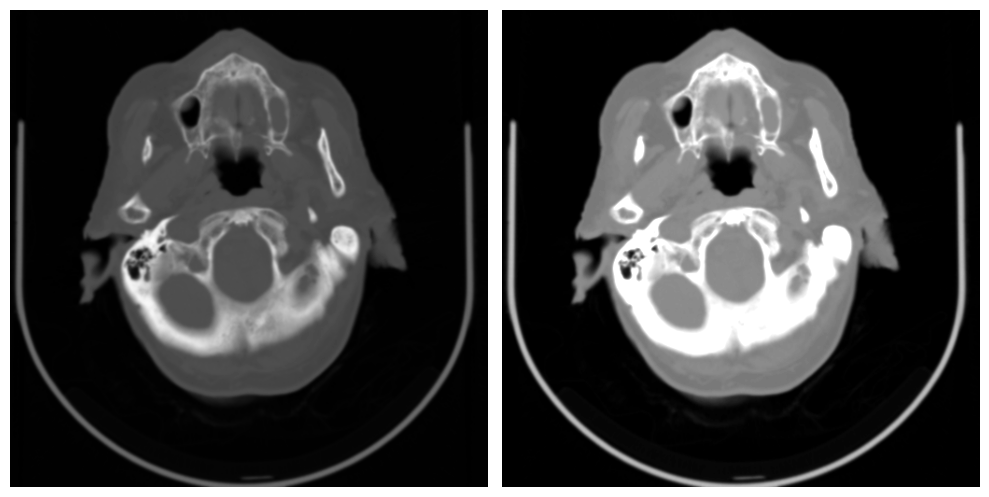

In [25]:
def window_percentile_v2(image):
    p5, p95 = np.percentile(image, 5), np.percentile(image, 95)
    adj_img = np.clip(image, p5, p95)
    adj_img = ((adj_img - p5)/(p95 - p5) * 255).astype(np.uint8)
    return adj_img

def window_percentile_uint8():
    fig, axes = plt.subplots(1, 2, figsize=(10,10))
    axes[0].imshow(pixel_data_uint8, cmap='gray')
    axes[0].axis('off')
    axes[1].imshow(window_percentile_v2(pixel_data_uint8), cmap='gray')
    axes[1].axis('off')
    plt.tight_layout()
    plt.show()

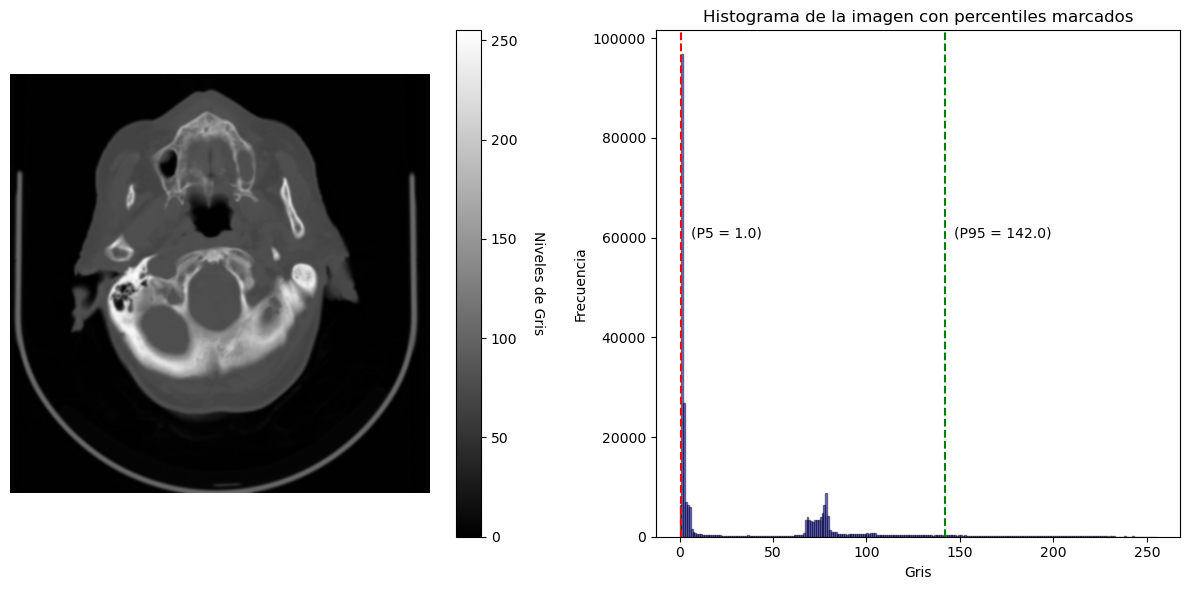

In [19]:

def plots_histogram_percentile(image):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Imagen
    ax = axes[0]
    im = ax.imshow(image, cmap='gray')
    ax.axis('off')
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Niveles de Gris', rotation=270, labelpad=20)
    
    # Histograma
    ax = axes[1]
    p5, p95 = np.percentile(image, 5), np.percentile(image, 95)
    ax.hist(image.flatten(), bins=255, alpha=0.5, color='blue', edgecolor='black')
    # Mostrar la posición de los percentiles
    ax.axvline(p5, color='red', linestyle='--', label=f'Percentil 5 ({p5: .2f})')
    ax.axvline(p95, color='green', linestyle='--', label=f'Percentil 95 ({p95: .2f})')
    # Marcar los percentiles
    ax.text(p5 + 5, 60000, f'(P5 = {p5})')
    ax.text(p95 + 5, 60000, f'(P95 = {p95})')
    
    ax.set_xlabel('Gris')
    ax.set_ylabel('Frecuencia')
    ax.set_title('Histograma de la imagen con percentiles marcados')
    
    plt.tight_layout()
    plt.show()
    
plots_histogram_percentile(pixel_data_uint8)

#### Window to 5% and 95% percentile of gray scale

##### What is a percentile? 
A percentile is a statistical concept used to represent a specific position or rank within a dataset. It indicates the value below which a given percentage of data points fall. In simpler terms, a percentile helps you understand how a particular data point compares to others in a dataset.

For example, if you hear that a score of 90 on a test is at the 90th percentile, it means that 90% of the test-takers scored lower than that value, and only 10% scored higher. Percentiles are often used in various fields, including statistics, education, healthcare, and economics, to analyze and interpret data distributions and make comparisons based on relative positions within the data.

In the context of medical imaging and grayscale values, the 5th and 95th percentiles represent specific values within the grayscale pixel distribution.

1. **5th Percentile**: The 5th percentile represents a specific value below which 5% of the pixels in the image fall. In other words, it indicates that 5% of the pixels have values lower than or equal to the 5th percentile value. 5% of pixels have values at or below this value.

2. **95th Percentile**: The 95th percentile represents a value below which 95% of the pixels in the image fall. It indicates that 95% of the pixels have values lower than or equal to the 95th percentile value. 95% of pixels have values at or below this value. 

###### Python implementation

The python implementation is very similar to the last exercise, begin wmin = 5 percenitle and wmax = 95 percentile, since 95perc > 5perc. 

In [14]:
def adjust_contrast(image):
    """
    :param image: Input
    :return: Return the input image clipped into the 1 and 99 percentile
    """
    # Calculate the 1% and 99% percentiles
    percentile_1 = np.percentile(image, 1)
    percentile_99 = np.percentile(image, 99)

    # Clip the image between the 1% and 99% percetile
    adj_image = np.clip(image, percentile_1, percentile_99)
    
    # Set the intial value to zero and set the pixels into the interval
    adj_image = ((adj_image - percentile_1)/(percentile_99 - percentile_1) * 255).astype(np.uint8)
    return adj_image

# Calculate the adjusted image
adjusted_dcm = adjust_contrast(pixel_data)
# Upscale the images
upscaled_image = scale_image(pixel_data, 2)
upscaled_perc_ver2 = scale_image(adjusted_dcm, 2)
# Show both images
cv2.imshow('Original image', upscaled_image)
cv2.imshow('Contrast adjusted image', upscaled_perc_ver2)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Resultados finales

In [52]:
# window_percentile_v2 lineal_window adj_gamma get_negative

def plt_results(image, algorithms):
    plt.figure(figsize=(15, 15))
    plt.subplot(3, 3, 2)  
    plt.imshow(image, cmap='gray')
    plt.title("Original image")
    plt.axis('off')
    names = list(algorithms.keys())
    positions = [4, 5, 6, 7, 8, 9]  
    for i, (pos, alg) in enumerate(zip(positions, algorithms.values())):
        plt.subplot(3, 3, pos)
        plt.imshow(alg, cmap='gray')
        plt.title(f"{names[i]} image")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


im = pixel_data_uint8
functionsv1 = {'Masked': apply_red_mask_to_dicom(im, 105, 255, plots=False),
             'Negative': get_negative(im), 
             'Gamma 2': adj_gamma(im, 2), 
             'Gamma 0.5': adj_gamma(im, 0.5), 
             'Window': lineal_window(im, 88, 150), 
             'Percentile Window': window_percentile_v2(im)}

# plt_results(im, functions)

## Guardar las imágenes

In [53]:
functions = {'Negative': get_negative(im),
             'Gamma 2': adj_gamma(im, 2),
             'Gamma 0.5': adj_gamma(im, 0.5),
             'Window': lineal_window(im, 88, 150),
             'Percentile Window': window_percentile_v2(im)}

for algorithm in list(functions.keys()):
    # Establecer las rutas y nombre de archivo
    ruta_JPG = os.path.join('C://Users//mario//DataspellProjects//dicom_files_python//JPEG_output', f'JPEG_{algorithm}.jpg')
    ruta_PNG = os.path.join('C://Users//mario//DataspellProjects//dicom_files_python//PNG_output', f'PNG_{algorithm}.png')
    # Guardar las imágenes
    plt.imsave(ruta_JPG, functions.get(algorithm), cmap='gray')
    plt.imsave(ruta_PNG, functions.get(algorithm), cmap='gray')

### Comparación de percentiles

In [26]:
path2 = 'C://Users\mario_q8nmnbl\DataSpell\Biomedical_images_University\DICOM_files\dicom_files_data\pout.jpg'

im = cv2.imread(path2, cv2.IMREAD_GRAYSCALE)

# Calculate the adjusted image
adjusted_pout1 = adjust_contrast(im)
adjusted_pout2 = window_percentile(im)
# Upscale the images
upscaled_image = scale_image(im, 1.2)
upscaled_perc_ver2 = scale_image(adjusted_pout1, 1.2)
upscaled_perc_ver3 = scale_image(adjusted_pout2, 1.2)
# Show both images
cv2.imshow('Original image', upscaled_image)
cv2.imshow('1/99 Contrast adjusted image', upscaled_perc_ver2)
cv2.imshow('5/95 Contrast adjusted image', upscaled_perc_ver3)

cv2.waitKey(0)
cv2.destroyAllWindows()


NameError: name 'adjust_contrast' is not defined